# Exercise Sheet 4: Machine Learning Fundamentals & Linear Regression (Deadline: 01 Dec 23:59)

# ML Fundamentals(7 points)
For theoretical tasks you are encouraged to write in $\\LaTeX$. Jupyter notebooks support them by default. For reference, please have a look at the examples in this short excellent guide: [Typesetting Equations](http://nbviewer.jupyter.org/github/ipython/ipython/blob/3.x/examples/Notebook/Typesetting%20Equations.ipynb)

Alternatively, you can upload the solutions in the written form as images and paste them inside the cells. But if you do this, **make sure** that the images are of high quality, so that we can read them without any problems.

###### 1. Sigmoid Function (1.5 points)
The special case of the logistic function is the *sigmoid function* which is defined as:

\begin{equation*}
  \sigma(a) = \frac{1}{1 + e^{-a}}
\end{equation*}

a) Compute its gradient analytically. (0.5 points)

b) What are the inherent properties that you observe from the above computed gradient? (0.5 points) <br />
   *Hint: Think about how would the gradient signal be for the whole domain of the sigmoid function*

c) Prove that the sigmoid function is symmetric. (0.5 points)

###### 2. Regularization (3.5 points)

In the lecture, we've seen that we can add a *regularizer* to our cost function to avoid *over or underfitting*. For example, consider the following training criterion for linear regression:

\begin{equation*}
  J(\textbf{w}) = \frac{1}{m}\sum_{i=1}^{m} \Vert\hat{y}^{(i)} - y^{(i)}\Vert^{2} + \lambda\Omega(\textbf{w})
\end{equation*}
where $\Omega(\textbf{w}) = \textbf{w}^{T}\textbf{w}$ is the regularizer.

a) In the above criterion, what is the role of the regularization parameter $\lambda$ on the regularizer (i.e. parameters of our model) while minimizing $J(\textbf{w})$? (1.0 point)

b) Is $\lambda$ the model parameter or a hyperparameter? Justify.(0.5 points)

c) Derive the closed form solution for the weights ($\textbf{w}$) in the above criterion.(2.0 points)

###### 3. Maximum Likelihood Estimation (MLE) (2 points)
Consider the density function of a ***univariate Gaussian distribution***


\begin{equation*}
 p(x;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}exp\left(-\frac{1}{2\sigma^2}(x-\mu)^{2}\right)
\end{equation*}
where $\mu$ is the $\textit{mean}$ and $\sigma^{2}$ is the $\textit{variance}$. 

Let's say you're given *N* samples (i.e. $x_1, x_2, x_3, ..., x_N$) which are drawn from the above stated distribution. Also, you can assume that these samples are **i.i.d** (i.e. [independent and identically distributed](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables)).

Now, please derive the *MLE step-by-step* for:

a) *mean* $(\mu)$. (1.0 point)

b) *variance* $(\sigma^2)$. (1.0 point)

# Multiple Linear Regression (13 points)

#### 1. Introduction
As we have seen in first assignment sheet, when we have one independent (or explanatory) variable and a scalar dependent variable, it is called **simple linear regression**.
But, when there are more than one explanatory variable (i.e. $x^{(1)}, x^{(2)}, ...,x^{(k)}$), and a single scalar dependent variable (*y*), then it's called $\textit{multiple linear regression}$. (Please don't confuse this with *multivariate linear regression* where we predict more than one (correlated) dependent variable.)

Here, we will implement a **multiple linear regression** model in Python/NumPy using the *Gradient Descent* algorithm. Particularly, we will be using $\textit{stochastic gradient descent}$ (*SGD*) where one performs the update step using a small set of training samples of size *batch_size* which we will set to 64. This is again a hyperparameter but in this exercise we will just use a fixed batch-size of *64* (i.e. we go through the training samples sampling 64 at a time and perform gradient descent.) Such a procedure is sometimes called *mini-batch gradient descent* in the deep learning community.

Going through all the training samples *once* is called an **epoch**. Ideally, the algorithm has to go through multiple epochs over the training samples, each time shuffling it, until a convergence criterion has been satisfied. <br />

Here, we will set a *tolerance value* for the difference in error (i.e. change in MSE values between subsequent epochs) that we will accept. Once this difference falls below the *tolerance value*, we terminate our training phase and return the parameters. 

We repeat the above training procedure for all possible hyperparameter combinations. Later on, using these parameters (*i.e. weight vectors*), we compute the prediction for validation data and the corresponding MSE values. And then, we pick the hyperparameter combination which yielded the least MSE.

As a next step, we will combine training data and validation data and make it as our *new training data*. We keep the test data as it is. Using the hyperparameter combination (for the least MSE) that we found above, we train the model again with the *new training data* and obtain the parameter (*i.e. weight vector*) after convergence according to our *tolerance value*.

Phew! That will be our much desired *weight vector*. This is then used on the *test data*, which has not been seen by our algorithm so far, to make a prediction. The resulting MSE value will be the so-called [*generalization error*](https://en.wikipedia.org/wiki/Generalization_error).

It is this *generalization error* that we want it to be as low as possible for *unseen data* (implies that we can achieve higher accuracy).

#### 2. Dataset
For our task, we will be using the *Wine Quality* dataset and predict the quality of white wine based on 11 features such as acidity, citric acid content, residual sugar etc. .

In [321]:
%matplotlib inline
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# get data
data_url = 'http://mlr.cs.umass.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
data = pd.read_csv(data_url, sep=';')

# inspect data
print(data.head())
#print(data.shape)

# data as np array
data = data.values

print(data)

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6 

#### 3. Loss function
We will use a *regularized* form of the MSE loss function. In matrix form it can be written as follows:

\begin{equation*}
    J(\textbf{w}) = \frac{1}{2} \Vert{X\textbf{w}-\textbf{y}}\Vert^{2} + \frac{\lambda}{2}\Vert{\textbf{w}}\Vert^{2}
\end{equation*}

It's important to note that, in the above equation, $X$, called *design matrix*, is the horizontal concatenation of shape *(batch_size, num_features)* according to the *order* of the polynomial. To make things easier, you can add the *bias* term as the first column of $X$. Take care to have the *weight* vector $\textbf{w}$ with matching dimensions.

$\textit{Hint}$: see [Design_matrix#Multiple_regression](https://en.wikipedia.org/wiki/Design_matrix#Multiple_regression) for how $X$ with 2 features looks like for $1^{st}$ degree polynomial.

a) Derive the gradient (w.r.t $\textbf{w}$) for the regularized loss function given in **3**. (1.0 point)

\begin{equation*}
    J(\textbf{w}) = \frac{1}{2m} ({X\textbf{w}-\textbf{y}})^{T}({X\textbf{w}-\textbf{y}}) + \frac{\lambda}{2m}\sum_{j=1}^{n}{\textbf{w}_j}^{2}
\end{equation*}
\begin{equation*}
\nabla_wJ(\textbf{w}) = X^T({X\textbf{w}-\textbf{y}})+ \lambda\textbf{w}
\end{equation*}

#### 4. Matrix format for higher order polynomial

Written in matrix form, linear regression model for second order would look like: <br />
$$\hat{\textbf{y}} = X\textbf{w}_{1} + X^{2}\textbf{w}_{2} + \textbf{b}$$

where $X^{2}$ is the element-wise squaring of the original design matrix $X$, $\textbf{w}_1$ and $\textbf{w}_2$ are the *weight* vectors, and **b** is the *bias* vector.

a) Now, please write down the matrix format for a $9^{th}$ order linear regression model (0.5 points)
$$\hat{\textbf{y}} =\textbf{b} + \sum_{i=1}^{9} w_{i}x^{i} $$

#### 5. Hyperparameters
we will experiment with three hyperparameters:

i) regularization parameter $\lambda$ <br />
ii) learning rate $\epsilon$ <br />
iii) order of polynomial *p*

And do a grid search over the values that these hyperparameters can take in order to select the best combination (i.e. the one that achieves lowest test error). This approach is called **hyperparameter optimization or tuning**.

In [322]:
polynomial_order = [1, 5, 9]
learning_rates = [1e-5, 1e-8]
lambdas = [0.1, 0.8]

#hyperparams combination
comb_gen = itertools.product(*(polynomial_order, learning_rates, lambdas))
hparams_comb = list(comb_gen)

batch_size = 64

#### 6. Normalization
First of all, inspect the data, and understand its structure and features. Ideally, before starting to train our learning algorithm, we would want the data to be normalized. Here, we normalize the data (i.e. normalize each column) using the formula:

\begin{equation*}
  norm\_x_i = \frac{x_i - min(x)}{max(x) - min(x)}
\end{equation*}
where $x_i$ is the $i^{th}$ sample in feature $x$

a) Complete the following function which performs normalization (i.e. normalizes columns of $X$). (0.5 points)

In [323]:
def data_normalization(data):
    data_normalized = (data - np.min(data,0)) / (np.max(data,0) - np.min(data,0))
    return data_normalized

# perform data normalization
data_normalized = data_normalization(data)
data_npr = data_normalized
print (data_npr)

[[ 0.30769231  0.18627451  0.21686747 ...,  0.26744186  0.12903226  0.5       ]
 [ 0.24038462  0.21568627  0.20481928 ...,  0.31395349  0.24193548  0.5       ]
 [ 0.41346154  0.19607843  0.24096386 ...,  0.25581395  0.33870968  0.5       ]
 ..., 
 [ 0.25961538  0.15686275  0.11445783 ...,  0.27906977  0.22580645  0.5       ]
 [ 0.16346154  0.20588235  0.18072289 ...,  0.18604651  0.77419355
   0.66666667]
 [ 0.21153846  0.12745098  0.22891566 ...,  0.11627907  0.61290323  0.5       ]]


In [324]:
def split_data(data_npr):
    # (in-place) shuffling of data_npr along axis 0
    np.random.shuffle(data_npr)

    n_tr = 3898
    n_va = n_tr + 500
    n_te = n_va + 500
    
    X_train = data_npr[0:n_tr, 0:-1]
    Y_train = data_npr[0:n_tr, -1]
    
    X_val = data_npr[n_tr:n_va, 0:-1]
    Y_val = data_npr[n_tr:n_va, -1]
    
    X_test = data_npr[n_va:, 0:-1]
    Y_test = data_npr[n_va:, -1]
    
    return [(X_train, Y_train), (X_val, Y_val), (X_test, Y_test)]


# shuffle only the training data along axis 0
def shuffle_train_data(X_train, Y_train):
    """called after each epoch"""
    perm = np.random.permutation(len(Y_train))
    Xtr_shuf = X_train[perm]
    Ytr_shuf = Y_train[perm]
    
    return Xtr_shuf, Ytr_shuf

###### 7. Implementation of required functions

Complete the following function which computes the MSE value. (0.5 point) <br />
(i.e. just a vanilla version of it.) That is, you can ignore the regularization term and also the constants $\frac{1}{2}$

In [325]:
def compute_mse(prediction, ground_truth):
    # TODO: implement
    ground_truth = np.reshape(ground_truth, (np.shape(ground_truth)[0], 1))
    mse = np.mean(np.square(prediction - ground_truth))
    return mse

prediction = np.array([1, 3, 6])
truth = np.array([0, 0, 0])
mse = compute_mse(prediction, truth)
print (mse)

15.3333333333


Implement a function which computes the prediction of your model. (0.5 point)

In [326]:
def get_prediction(X, W):
    # TODO: implement
    Yhat = np.matmul(X, W)
    return Yhat

dataset = [[1, 1], [2, 3], [4, 3], [3, 2], [5, 5]]
coef = [0.4, 0.8]
for row in dataset:
    yhat = get_prediction(dataset, np.transpose(coef))
    
print (yhat)

[ 1.2  3.2  4.   2.8  6. ]


Implement a function which computes the gradient of your loss function. (1.0 point) <br />
*Hint: Just implementing the gradient computed in **3.** (a)*

In [327]:
def compute_gradient(X, Y, Yhat, W, lambda_):
    # TODO: implement
    Y = np.reshape(Y, (np.shape(Y)[0],1))
    X_T = np.transpose(X)
    gradient = np.matmul(X_T,(Yhat - Y)) + lambda_ * W
    return gradient


Implement a function which performs a single update step of SGD. (0.5 point)

In [328]:
# Hint: avoid in-place modification
def sgd(gradient, lr, cur_W):
    # TODO: implement
    new_W = cur_W - (lr * gradient)
    return new_W


Complete the following function which reformats your data as a design matrix. (0.5 point)

In [329]:
# concatenate X acc. to order of polynomial; likewise do it for W
# where X is design matrix, W is the corresponding weight vector
# [1 X X^2 X^3], [1 W1 W2 W3].T

#this function is not done yet
def prepare_data_matrix(X, W, order):
    # TODO: implement
    X_mat = np.ones(shape=(np.shape(X)[0],1))
    W_vec = np.ones(1)
    for i in range(order):
        X_new = X ** (i+1)
        X_mat = np.c_[X_mat, X_new]
        W_vec = np.transpose(np.c_[np.transpose(W_vec), np.transpose(W)])
    return X_mat, W_vec

# X = np.array([[1, 2, 3], [4, 5, 6]], np.int32)
# W = np.array([[1, 2, 3]], np.int32)
# x_mat, w_vec = prepare_data_matrix(X, W, 3)
# print (x_mat.shape)
# print (w_vec)
# # prediction = get_prediction(x_mat, w_vec)

###### 8. Training
Complete the code in the following cell such that it performs **mini-batch gradient descent** on the training data for all possible hyperparameter combinations. (4.0 points)

Note: You can also define a function, named appropriately, which performs training. But, take care to do correct bookkeeping of hyperparameter combinations, weight vectors, and the MSE values.

In [330]:
splits = split_data(data_npr)
X_train, Y_train, X_val, Y_val, X_test, Y_test = itertools.chain(*splits)

tolerance = 1e-6
start = 1

# initialize weight vector from normal distribution
# TODO: implement
W_init = np.array([np.random.randn(np.shape(X_train)[1])])
W_init = np.transpose(W_init)


# cache weights for each hyperparam combination
# TODO: implement
weights_hist = {}
for order in polynomial_order:
    for lr in learning_rates:
        for lamb in lambdas:
            weights_hist[(order, lr, lamb)] = W_init

# keep track of MSE for each hparam combination. will be useful for plotting
# TODO: implement
mse_hist = {}
for order in polynomial_order:
    for lr in learning_rates:
        for lamb in lambdas:
            mse_hist[(order, lr, lamb)] = np.finfo(np.float64).max

# find optimal hyperparameters
for order in polynomial_order:
    for lr in learning_rates:
        for lamb in lambdas:
            # initialize necessary stuffs
            # TODO: implement
            
            # design matrix needed at this point
            # use the function that we defined above
            # TODO: implement
            X_mat, W_vec = prepare_data_matrix(X_train, W_init, order)
            Y_vec = Y_train

            epochs = 1
            # goes through multiple epochs
            while True:
                # good idea to shuffle the train data
                # TODO: implement
                X_mat, Y_vec = shuffle_train_data(X_mat, Y_vec)
                
                # some more initialization
                # TODO: implement
                bs = 0
                nsamples = np.shape(X_mat)[0]
#                 prediction = np.empty(Y_vec.shape)
                # goes through 1 epoch
                while bs < nsamples:
                    X = X_mat[bs:bs + batch_size, ]
                    Y = Y_vec[bs:bs + batch_size, ]
                    predictions = get_prediction(X, W_vec)
                    gradient = compute_gradient(X, Y, predictions, W_vec, lamb)
                    W_vec = sgd(gradient, lr, W_vec)
                    bs = bs + batch_size
                    # complete code for 1 epoch
                    # TODO: implement
                    
                # after each epoch
                # get prediction for whole X_train
                # compute the MSE
                # might need to do bookkeeping of mse values as well
                batch_predictions = get_prediction(X_mat, W_vec)
                mse = compute_mse(batch_predictions, Y_vec)
                mse_h = mse_hist[(order, lr, lamb)]
                mse_hist[(order, lr, lamb)] = mse
#               print("Convergence after epoch {} with MSE {}".format(epochs, mse), "\n")

                # stopping/convergence criterion
                # check whether diff-in-mse < tolerance
                # TODO: implement
                diff_in_mse = np.abs(mse_h - mse)
                if(diff_in_mse < tolerance):
                    weights_hist[(order, lr, lamb)] = W_vec
                    print("order: {} , learning rate: {} , regularizer: {} ".format(order, lr, lamb))
                    print("Convergence after epoch {} with MSE {}".format(epochs, mse), "\n")
                    break
                epochs += 1
                
                    # cache weight vector for later use
                    # but we also need the hparam combination
                    # TODO: implement
                
            

order: 1 , learning rate: 1e-05 , regularizer: 0.1 
Convergence after epoch 5794 with MSE 0.01785756986515437 

order: 1 , learning rate: 1e-05 , regularizer: 0.8 
Convergence after epoch 2717 with MSE 0.01675537633160378 

order: 1 , learning rate: 1e-08 , regularizer: 0.1 
Convergence after epoch 37234 with MSE 0.1971833073389221 

order: 1 , learning rate: 1e-08 , regularizer: 0.8 
Convergence after epoch 39086 with MSE 0.1901271572426883 

order: 5 , learning rate: 1e-05 , regularizer: 0.1 
Convergence after epoch 8160 with MSE 0.018520469309808833 

order: 5 , learning rate: 1e-05 , regularizer: 0.8 
Convergence after epoch 3371 with MSE 0.0166590380087997 

order: 5 , learning rate: 1e-08 , regularizer: 0.1 
Convergence after epoch 273938 with MSE 0.40929591276496646 

order: 5 , learning rate: 1e-08 , regularizer: 0.8 
Convergence after epoch 286693 with MSE 0.31145224617016487 

order: 9 , learning rate: 1e-05 , regularizer: 0.1 
Convergence after epoch 9835 with MSE 0.01863478

Complete the following function which selects the best hyperparameter combination (i.e. the one that gives lowest MSE on **validation data**). (0.5 point)

In [335]:
# find hparams of minimum MSE on Validation data
def find_best_hparams(weights_hist):
    # TODO: implement
    mse_best = np.finfo(np.float64).max
    for order in polynomial_order:
        for lr in learning_rates:
            for lamb in lambdas:
                X_mat, W_vec = prepare_data_matrix(X_val, weights_hist[(order, lr, lamb)], order)
                Y_vec = Y_val 
                prediction = get_prediction(X_mat, weights_hist[(order, lr, lamb)])
                mse = compute_mse(prediction, Y_vec)
                if(mse < mse_best):
                    mse_best = mse
                    best_hpm_combination = (order, lr, lamb)
    return best_hpm_combination
                    

best_hpm_combination = find_best_hparams(weights_hist)
print (best_hpm_combination)

(1, 1e-05, 0.8)


###### 9. Re-Training on Train + Validation data
Complete the following function which does re-training on the combined training and validation data. (**1 point**)

In [336]:
# re-run the training on X_train + X_val combined
# Later test it on X_test; That will be our best possible MSE on test data
# this will be more or less the same training code as you did above
# but, here we just have only one value for each hyperparameter.
X_com = np.transpose(np.c_[np.transpose(X_train), np.transpose(X_val)])
Y_train = np.reshape(Y_train, (np.shape(Y_train)[0],1))
Y_val = np.reshape(Y_val, (np.shape(Y_val)[0],1))
Y_com = np.transpose(np.c_[np.transpose(Y_train), np.transpose(Y_val)])



X_mat, W_vec = prepare_data_matrix(X_com, W_init, order)
Y_vec = Y_com

order, lr, lamb = best_hpm_combination
mse_list = []
index = 0
mse_list.append(np.finfo(np.float64).max)
epochs = 1
# goes through multiple epochs
while True:
    
    X_mat, Y_vec = shuffle_train_data(X_mat, Y_vec)
    bs = 0
    nsamples = np.shape(X_mat)[0]
    while bs < nsamples:
        X = X_mat[bs:bs + batch_size, ]
        Y = Y_vec[bs:bs + batch_size, ]
        predictions = get_prediction(X, W_vec)
        gradient = compute_gradient(X, Y, predictions, W_vec, lamb)
        W_vec = sgd(gradient, lr, W_vec)
        bs = bs + batch_size
                    
    batch_predictions = get_prediction(X_mat, W_vec)
    mse = compute_mse(batch_predictions, Y_vec)
    mse_h = mse_list[index]
    index += 1
    mse_list.append(mse)
    diff_in_mse = np.abs(mse_h - mse)
    if(diff_in_mse < tolerance):
        weights_best = W_vec
        print("order: {} , learning rate: {} , regularizer: {} ".format(order, lr, lamb))
        print("Convergence after epoch {} with MSE {}".format(epochs, mse), "\n")
        break
    epochs += 1


order: 1 , learning rate: 1e-05 , regularizer: 0.8 
Convergence after epoch 2450 with MSE 0.017036767092912696 



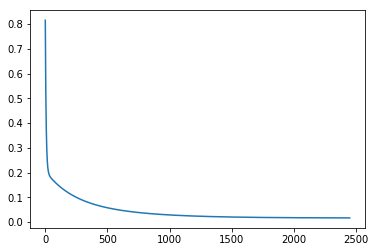

In [337]:
# plot the convergence of MSE values using matplotlib
# i.e. #epochs on X-axis and MSE values on Y-axis
# TODO: implement
plot = plt.subplot(1, 1, 1)
plot.plot(range(epochs),mse_list[1:len(mse_list)])

###### 10. Evaluation on Test set
Evaluate your model on test data. (1.0 point)

**Please note that you should keep X_test undisturbed throughout this whole phase.** Else restart the kernel and start from beginning. The whole point of this exercise would not make sense if test data has been *seen in training*.

In [338]:
# finally!!!
# test it on X_test with the Weight vector that you found above
# this will be the generalization error of our model!!
# TODO: implement
X_mat, _ = prepare_data_matrix(X_test, W_init, order)
# print(weights_best)
predictions = get_prediction(X_mat, weights_best)
mse_test = compute_mse(predictions, Y_test)
print("Finally!!! MSE achieved on X_test is : {}".format(round(mse_test, 6)))

Finally!!! MSE achieved on X_test is : 0.014996


###### 11. Results
Please report the following

a) MSE value on Test data. (0.5 points)

b) Which hyperparameter combination turned out to be the best? In your understanding, why do you think such a combination turned out to be the best for this task? (1.0 point)

# Bonus (2 points)

Now, please repeat the whole *training, validation, re-training, and testing* procedure that we talked about above with the following hyperparameter combination:

In [ ]:
polynomial_order = [1]
learning_rates = [0.1]
lambdas = [0.1]

What are your observations during the training phase? Please explain why such a behaviour happened.

---

## Submission instructions
You should provide a single Jupyter notebook as the solution. The naming should include the assignment number and matriculation IDs of all members in your team in the following format:
**assignment-4_matriculation1_matriculation2_matriculation3.ipynb** (in case of 3 members in a team). 
Make sure to keep the order matriculation1_matriculation2_matriculation3 the same for all assignments.

Please submit the solution to your tutor (with **[NNIA][assignment-4]** in email subject):
1. Maksym Andriushchenko <s8mmandr@stud.uni-saarland.de>
2. Marius Mosbach <s9msmosb@stud.uni-saarland.de>
3. Rajarshi Biswas <rbisw17@gmail.com>
4. Marimuthu Kalimuthu <s8makali@stud.uni-saarland.de>

Note: **If you are in a team, please submit only 1 solution to only 1 tutor.**